# Générateur de Noms de Domaine avec LLM
## Expérimentations et Évaluations Systématiques

Ce notebook présente le développement itératif d'un système de génération de noms de domaine utilisant des modèles de langage, avec un focus sur l'évaluation automatisée et la découverte de cas limites.

## 1. Configuration et Imports

In [1]:
import sys
import os
sys.path.append("..")
import numpy as np
import pandas as pd
import seaborn as sns
import collections
from datetime import datetime
import matplotlib.pyplot as plt

# Import des modules du projet
from src.creation_dataset import CreationDataset
from src.generateur_nom_domaine import GenerateurNomsDomaine
from src.utils import charger_json, sauvegarder_json, generer_timestamp
from src.evaluateur_llm import EvaluateurLLM


print(f"Date de l'expérience: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Date de l'expérience: 2025-08-04 00:35:57


## 2. Création du Dataset Synthétique

Nous commençons par créer un dataset synthétique diversifié pour l'évaluation.

In [2]:
# Initialiser le créateur de dataset
creation_dataset = CreationDataset()

# Créer le dataset complet
print("Création du dataset synthétique...")
chemin_dataset = creation_dataset.sauvegarder_dataset("dataset_experimental.json")

# Charger et analyser le dataset créé
dataset_complet = charger_json(chemin_dataset)

print(f"Dataset créé avec succès:")
print(f"   - Exemples d'entraînement: {len(dataset_complet['entrainement'])}")
print(f"   - Cas limites: {len(dataset_complet['cas_limites'])}")

# Visualisation de la distribution des types de business
descriptions = [ex['description_business'] for ex in dataset_complet['entrainement']]
print(f"\nExemples de descriptions générées:")
for i, desc in enumerate(descriptions[:5]):
    print(f"   {i+1}. {desc}")

INFO:src.utils:Génération d'un dataset de 1000 exemples...
INFO:src.utils:Généré 100/1000 exemples
INFO:src.utils:Généré 200/1000 exemples
INFO:src.utils:Généré 300/1000 exemples
INFO:src.utils:Généré 400/1000 exemples
INFO:src.utils:Généré 500/1000 exemples
INFO:src.utils:Généré 600/1000 exemples
INFO:src.utils:Généré 700/1000 exemples
INFO:src.utils:Généré 800/1000 exemples
INFO:src.utils:Généré 900/1000 exemples
INFO:src.utils:Généré 1000/1000 exemples
INFO:src.utils:Données sauvegardées dans ../data/dataset_experimental.json
INFO:src.utils:Dataset complet sauvegardé: ../data/dataset_experimental.json
INFO:src.utils:Données chargées depuis ../data/dataset_experimental.json


Création du dataset synthétique...
Dataset créé avec succès:
   - Exemples d'entraînement: 1000
   - Cas limites: 14

Exemples de descriptions générées:
   1. Nouveau vente beauté artisanal à centre commercial
   2. Service de dentaire via centre
   3. abordable restaurant français dans bord de mer
   4. Service de mobile via startup abordable
   5. Nouveau bistro asiatique à bord de mer


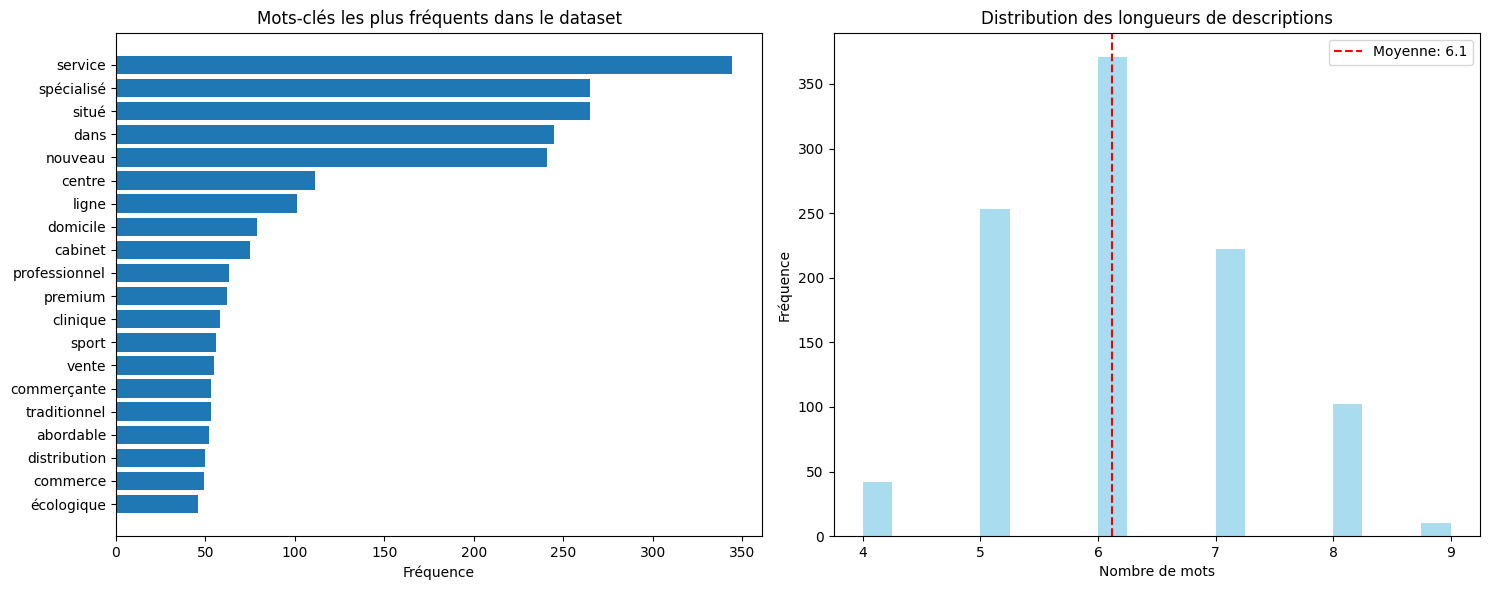

Statistiques du dataset:
   - Longueur moyenne des descriptions: 6.1 mots
   - Longueur médiane: 6.0 mots
   - Vocabulaire unique: 90 mots


In [3]:
# Analyser les mots-clés les plus fréquents
tous_mots = []
for desc in descriptions:
    mots = desc.lower().split()
    tous_mots.extend([mot for mot in mots if len(mot) > 3])

mots_frequents = collections.Counter(tous_mots).most_common(20)

# Créer une visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Graphique des mots les plus fréquents
mots, freq = zip(*mots_frequents)
ax1.barh(range(len(mots)), freq)
ax1.set_yticks(range(len(mots)))
ax1.set_yticklabels(mots)
ax1.set_xlabel('Fréquence')
ax1.set_title('Mots-clés les plus fréquents dans le dataset')
ax1.invert_yaxis()

# Distribution des longueurs de descriptions
longueurs = [len(desc.split()) for desc in descriptions]
ax2.hist(longueurs, bins=20, alpha=0.7, color='skyblue')
ax2.set_xlabel('Nombre de mots')
ax2.set_ylabel('Fréquence')
ax2.set_title('Distribution des longueurs de descriptions')
ax2.axvline(np.mean(longueurs), color='red', linestyle='--', label=f'Moyenne: {np.mean(longueurs):.1f}')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"Statistiques du dataset:")
print(f"   - Longueur moyenne des descriptions: {np.mean(longueurs):.1f} mots")
print(f"   - Longueur médiane: {np.median(longueurs):.1f} mots")
print(f"   - Vocabulaire unique: {len(set(tous_mots))} mots")

## 3. Initialisation du Modèle Générateur

Configuration et test initial du générateur basé sur Llama3.1

In [4]:
# Initialiser le générateur de base
print("Initialisation du générateur de noms de domaine...")
try:
    generateur = GenerateurNomsDomaine(model="llama3.1", garde_fous=True, garde_fous_use_llm=False)
    info_modele = generateur.obtenir_info_modele()
    
    print("Générateur initialisé avec succès")
    print(f"   - Modèle: {info_modele['nom_modele']}")
    print(f"   - URL de base: {info_modele['base_url']}")
    print(f"   - Garde-fous activés: {info_modele['garde_fous_actifs']}")
    print(f"   - Styles disponibles: {', '.join(info_modele['styles_disponibles'])}")
    
except Exception as e:
    print(f"Erreur lors de l'initialisation: {e}")
    print("Vérifiez qu'Ollama est en cours d'exécution et que le modèle llama3.1 est téléchargé")
    print("   Commandes à exécuter:")
    print("   - ollama serve")
    print("   - ollama pull llama3.1")

INFO:src.utils:Modèle llama3.1 initialisé avec succès


Initialisation du générateur de noms de domaine...
Générateur initialisé avec succès
   - Modèle: llama3.1
   - URL de base: http://localhost:11434
   - Garde-fous activés: True
   - Styles disponibles: professionnel, creatif, moderne, classique, court


In [5]:
# Test initial avec des exemples variés
descriptions_test = [
    "restaurant italien familial avec terrasse au centre-ville",
    "startup de développement d'applications mobiles innovantes",
    "cabinet de conseil en marketing digital pour PME",
    "boutique de vêtements bio et éthiques en ligne",
    "école de formation en intelligence artificielle"
]

print("Tests initiaux du générateur ...\n")

resultats = []

for i, description in enumerate(descriptions_test, 1):
    print(f"Test {i}/{len(descriptions_test)}: {description}")

    try:
        resultat = generateur.generer_suggestions(
            description_business=description,
            nombre_suggestions=3,
            style="professionnel"
        )
        
        if resultat["status"] == "success":
            print("Suggestions générées:")
            for suggestion in resultat["suggestions"]:
                print(f"   - {suggestion['domaine']} (confiance: {suggestion['confidence']})")
            print(f"   Durée: {resultat['metadata']['duree_generation_sec']}s\n")
            
            resultats.append({
                "description": description,
                "resultats": resultat
            })
        else:
            print(f"Échec: {resultat.get('message', 'Erreur inconnue')}\n")
            
    except Exception as e:
        print(f"Erreur: {e}\n")

print(f"Tests baseline terminés: {len(resultats)}/{len(descriptions_test)} réussis")

INFO:src.utils:Génération de 3 | suggestions pour: restaurant italien familial avec terrasse au centr...


Tests initiaux du générateur ...

Test 1/5: restaurant italien familial avec terrasse au centre-ville


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées
INFO:src.utils:Génération de 3 | suggestions pour: startup de développement d'applications mobiles in...


Suggestions générées:
   - bellavista.com (confiance: 0.9)
   - familleitaliana.fr (confiance: 0.9)
   - terrazzatoscana.org (confiance: 0.8)
   Durée: 35.62s

Test 2/5: startup de développement d'applications mobiles innovantes


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 1 suggestions créées
INFO:src.utils:Génération de 3 | suggestions pour: cabinet de conseil en marketing digital pour PME...


Suggestions générées:
   - applilab.fr (confiance: 0.9)
   Durée: 37.53s

Test 3/5: cabinet de conseil en marketing digital pour PME


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 2 suggestions créées
INFO:src.utils:Génération de 3 | suggestions pour: boutique de vêtements bio et éthiques en ligne...


Suggestions générées:
   - advisiomarketing.fr (confiance: 0.7)
   - mcmediaconsulting.org (confiance: 0.6)
   Durée: 42.48s

Test 4/5: boutique de vêtements bio et éthiques en ligne


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées
INFO:src.utils:Génération de 3 | suggestions pour: école de formation en intelligence artificielle...


Suggestions générées:
   - vestbioethique.com (confiance: 0.9)
   - bloomecomode.fr (confiance: 0.9)
   - ecochic.net (confiance: 0.8)
   Durée: 45.26s

Test 5/5: école de formation en intelligence artificielle


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées


Suggestions générées:
   - artificialab.com (confiance: 0.9)
   - intelliform.fr (confiance: 0.9)
   - aiacademy.org (confiance: 0.8)
   Durée: 42.15s

Tests baseline terminés: 5/5 réussis


## 4. Implémentation du Système d'Évaluation LLM-as-a-Judge

Création d'un évaluateur automatique pour mesurer la qualité des suggestions de noms de domaine.

In [6]:
# Initialiser l'évaluateur LLM
print("⚖️ Initialisation du système d'évaluation LLM-as-a-Judge...")

try:
    evaluateur = EvaluateurLLM(type_evaluateur="openai", model="gpt-4o-mini") # Pour OpenAI
    # evaluateur = EvaluateurLLM(type_evaluateur="ollama", model="llama3.1") # Pour Ollama ==> llma3.1
    # evaluateur = EvaluateurLLM(type_evaluateur="ollama", model="deepseek-r1") # Pour Ollama ==> deepseek-r1
    print("Évaluateur initialisé avec succès")
    
    # Afficher les critères d'évaluation
    criteres = evaluateur.obtenir_criteres_evaluation()
    print("\nCritères d'évaluation:")
    for critere, description in criteres.items():
        print(f"   - {critere.capitalize()}: {description}")
        
except Exception as e:
    print(f"Erreur lors de l'initialisation de l'évaluateur: {e}")
    print("L'évaluateur utilisera le même modèle que le générateur")

⚖️ Initialisation du système d'évaluation LLM-as-a-Judge...


INFO:src.utils:Évaluateur OpenAI initialisé: gpt-4o-mini


Évaluateur initialisé avec succès

Critères d'évaluation:
   - Pertinence: Adéquation du nom de domaine à l'activité décrite
   - Creativite: Originalité et mémorabilité du nom
   - Memorabilite: Facilité de mémorisation et de pronunciation
   - Disponibilite_estimee: Probabilité que le domaine soit disponible
   - Professionnalisme: Aspect professionnel et sérieux du nom


In [7]:
# Test du système d'évaluation avec les résultats
print("Évaluation des résultats...\n")

evaluations_baseline = []

for i, resultat_test in enumerate(resultats, 1):
    description = resultat_test["description"]
    domaines = [s["domaine"] for s in resultat_test["resultats"]["suggestions"]]
    
    print(f"Évaluation {i}/{len(resultats)}: {description}")
    print(f"   Domaines proposés: {', '.join(domaines)}")
    
    try:
        evaluation = evaluateur.evaluer_suggestions(
            description_business=description,
            suggestions_domaines=domaines
        )
        
        if evaluation["status"] == "success":
            scores = evaluation["evaluations"]
            score_moyen = np.mean([s["score_total"] for s in scores])
            
            print(f"   Score moyen: {score_moyen:.2f}/10")
            
            # Afficher le détail du meilleur domaine
            meilleur = max(scores, key=lambda x: x["score_total"])
            print(f"   Meilleur: {meilleur['domaine']} ({meilleur['score_total']:.1f}/10)")
            print(f"   Pertinence: {meilleur['pertinence']:.1f}, Créativité: {meilleur['creativite']:.1f}")
            
            evaluations_baseline.append({
                "description": description,
                "domaines": domaines,
                "evaluations": evaluation
            })
        else:
            print(f"  Échec de l'évaluation: {evaluation.get('message', 'Erreur inconnue')}")

    except Exception as e:
        print(f"  Erreur: {e}")

    print()

print(f"Évaluations terminées: {len(evaluations_baseline)} complétées")

Évaluation des résultats...

Évaluation 1/5: restaurant italien familial avec terrasse au centre-ville
   Domaines proposés: bellavista.com, familleitaliana.fr, terrazzatoscana.org


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 6.90/10


   Score moyen: 6.90/10
   Meilleur: familleitaliana.fr (7.2/10)
   Pertinence: 9.0, Créativité: 6.0

Évaluation 2/5: startup de développement d'applications mobiles innovantes
   Domaines proposés: applilab.fr


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 7.20/10


   Score moyen: 7.20/10
   Meilleur: applilab.fr (7.2/10)
   Pertinence: 8.5, Créativité: 6.0

Évaluation 3/5: cabinet de conseil en marketing digital pour PME
   Domaines proposés: advisiomarketing.fr, mcmediaconsulting.org


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 6.35/10


   Score moyen: 6.35/10
   Meilleur: advisiomarketing.fr (7.2/10)
   Pertinence: 8.5, Créativité: 6.5

Évaluation 4/5: boutique de vêtements bio et éthiques en ligne
   Domaines proposés: vestbioethique.com, bloomecomode.fr, ecochic.net


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 6.63/10


   Score moyen: 6.63/10
   Meilleur: bloomecomode.fr (7.3/10)
   Pertinence: 7.5, Créativité: 8.5

Évaluation 5/5: école de formation en intelligence artificielle
   Domaines proposés: artificialab.com, intelliform.fr, aiacademy.org


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 7.13/10


   Score moyen: 7.13/10
   Meilleur: intelliform.fr (7.8/10)
   Pertinence: 9.0, Créativité: 7.0

Évaluations terminées: 5 complétées


Statistiques des évaluations baseline:
       score_total  pertinence  creativite  memorabilite  disponibilite
count    12.000000   12.000000   12.000000     12.000000      12.000000
mean      6.825000    8.000000    6.166667      7.083333       5.458333
std       0.699513    1.243163    1.134847      1.293925       1.814817
min       5.500000    5.500000    4.500000      4.500000       2.000000
25%       6.650000    7.375000    5.750000      6.375000       4.000000
50%       7.100000    8.500000    6.250000      7.250000       6.000000
75%       7.200000    8.625000    6.625000      8.000000       7.000000
max       7.800000    9.500000    8.500000      9.000000       7.500000


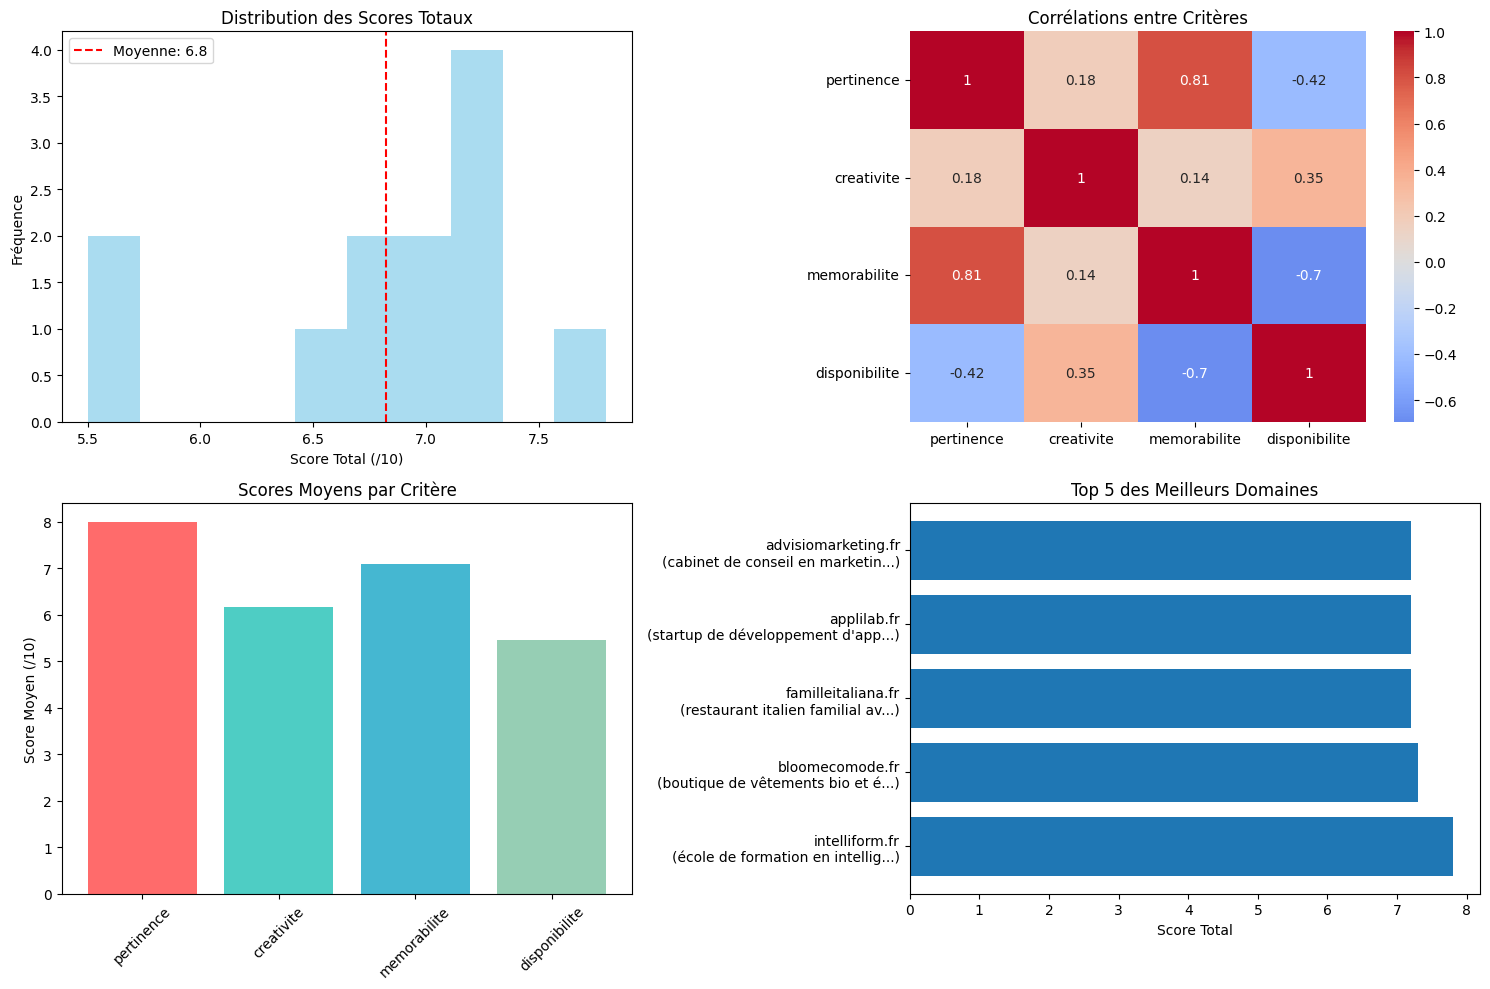

INFO:src.utils:Données sauvegardées dans ../data/evaluations/resultats_baseline.json



Analyse des performances baseline:
   - Score total moyen: 6.82/10
   - Critère le plus faible: disponibilite (5.46/10)
   - Critère le plus fort: pertinence (8.00/10)

Résultats baseline sauvegardés dans data/evaluations/resultats_baseline.json


In [8]:
# Analyse des résultats d'évaluation baseline
if evaluations_baseline:
    # Extraire tous les scores
    tous_scores = []
    for eval_result in evaluations_baseline:
        for eval_domaine in eval_result["evaluations"]["evaluations"]:
            tous_scores.append({
                "domaine": eval_domaine["domaine"],
                "description": eval_result["description"][:30] + "...",
                "score_total": eval_domaine["score_total"],
                "pertinence": eval_domaine["pertinence"],
                "creativite": eval_domaine["creativite"],
                "memorabilite": eval_domaine["memorabilite"],
                "disponibilite": eval_domaine["disponibilite_estimee"]
            })
    
    # Créer un DataFrame pour l'analyse
    df_scores = pd.DataFrame(tous_scores)
    
    print("Statistiques des évaluations baseline:")
    print(df_scores[['score_total', 'pertinence', 'creativite', 'memorabilite', 'disponibilite']].describe())
    
    # Visualisations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Distribution des scores totaux
    axes[0,0].hist(df_scores['score_total'], bins=10, alpha=0.7, color='skyblue')
    axes[0,0].set_title('Distribution des Scores Totaux')
    axes[0,0].set_xlabel('Score Total (/10)')
    axes[0,0].set_ylabel('Fréquence')
    axes[0,0].axvline(df_scores['score_total'].mean(), color='red', linestyle='--', 
                     label=f'Moyenne: {df_scores["score_total"].mean():.1f}')
    axes[0,0].legend()
    
    # Corrélation entre critères
    correlation_matrix = df_scores[['pertinence', 'creativite', 'memorabilite', 'disponibilite']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[0,1])
    axes[0,1].set_title('Corrélations entre Critères')
    
    # Scores par critère
    criteres = ['pertinence', 'creativite', 'memorabilite', 'disponibilite']
    moyennes_criteres = [df_scores[critere].mean() for critere in criteres]
    axes[1,0].bar(criteres, moyennes_criteres, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    axes[1,0].set_title('Scores Moyens par Critère')
    axes[1,0].set_ylabel('Score Moyen (/10)')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Top 5 des meilleurs domaines
    top_domaines = df_scores.nlargest(5, 'score_total')
    axes[1,1].barh(range(len(top_domaines)), top_domaines['score_total'])
    axes[1,1].set_yticks(range(len(top_domaines)))
    axes[1,1].set_yticklabels([f"{row['domaine']}\n({row['description']})" for _, row in top_domaines.iterrows()])
    axes[1,1].set_title('Top 5 des Meilleurs Domaines')
    axes[1,1].set_xlabel('Score Total')
    
    plt.tight_layout()
    plt.show()
    
    # Identifier les points faibles
    print("\nAnalyse des performances baseline:")
    print(f"   - Score total moyen: {df_scores['score_total'].mean():.2f}/10")
    print(f"   - Critère le plus faible: {criteres[np.argmin(moyennes_criteres)]} ({min(moyennes_criteres):.2f}/10)")
    print(f"   - Critère le plus fort: {criteres[np.argmax(moyennes_criteres)]} ({max(moyennes_criteres):.2f}/10)")
    
    # Sauvegarder les résultats baseline
    sauvegarder_json({
        "timestamp": generer_timestamp(),
        "version": "baseline",
        "evaluations": evaluations_baseline,
        "statistiques": {
            "score_moyen": float(df_scores['score_total'].mean()),
            "score_median": float(df_scores['score_total'].median()),
            "nombre_evaluations": len(df_scores)
        }
    }, "../data/evaluations/resultats_baseline.json")
    
    print("\nRésultats baseline sauvegardés dans data/evaluations/resultats_baseline.json")
    
else:
    print("Aucune évaluation baseline disponible pour l'analyse")

## 5. Découverte et Analyse des Cas Limites

Identification systématique des modes d'échec du modèle et classification des problèmes.

In [9]:
# Charger les cas limites du dataset
cas_limites = dataset_complet['cas_limites']

print(f"Analyse des cas limites ({len(cas_limites)} cas)...\n")

# Grouper par catégorie
categories_cas_limites = {}
for cas in cas_limites:
    categorie = cas['categorie']
    if categorie not in categories_cas_limites:
        categories_cas_limites[categorie] = []
    categories_cas_limites[categorie].append(cas)

print("Catégories de cas limites identifiées:")
for categorie, liste_cas in categories_cas_limites.items():
    print(f"   - {categorie.replace('_', ' ').title()}: {len(liste_cas)} cas")
    for cas in liste_cas[:2]:  # Afficher 2 exemples maximum
        print(f"     → \"{cas['description'][:60]}...\"")

Analyse des cas limites (14 cas)...

Catégories de cas limites identifiées:
   - Description Courte: 2 cas
     → "café..."
     → "tech..."
   - Description Longue: 1 cas
     → "Une entreprise de développement de logiciels spécialisée dan..."
   - Description Vague: 2 cas
     → "quelque chose de bien..."
     → "entreprise moderne..."
   - Caracteres Speciaux: 2 cas
     → "café & restaurant français..."
     → "entreprise high-tech à 100%..."
   - Langue Etrangere: 3 cas
     → "restaurant italiano molto buono..."
     → "English consulting firm..."
   - Concept Abstrait: 2 cas
     → "plateforme de bonheur digital..."
     → "solutions de bien-être énergétique..."
   - Niche Specifique: 2 cas
     → "réparation de violons anciens..."
     → "élevage de papillons exotiques..."


In [10]:
# Tester le générateur sur les cas limites
print("Test du générateur sur les cas limites...\n")

resultats_cas_limites = {}
echecs_par_categorie = {}

for categorie, liste_cas in categories_cas_limites.items():
    print(f"Test de la catégorie: {categorie}")
    resultats_categorie = []
    echecs_categorie = 0
    
    for i, cas in enumerate(liste_cas):
        description = cas['description']
        print(f"   Test {i+1}/{len(liste_cas)}: {description}")
        
        try:
            resultat = generateur.generer_suggestions(
                description_business=description,
                nombre_suggestions=3,
                style="professionnel",
                avec_filtrage=True
            )
            
            if resultat["status"] == "success":
                nb_suggestions = len(resultat["suggestions"])
                print(f"     {nb_suggestions} suggestions générées")
                
                # Évaluer la qualité si des suggestions ont été générées
                if nb_suggestions > 0:
                    domaines = [s["domaine"] for s in resultat["suggestions"]]
                    try:
                        evaluation = evaluateur.evaluer_suggestions(description, domaines)
                        if evaluation["status"] == "success":
                            score_moyen = np.mean([e["score_total"] for e in evaluation["evaluations"]])
                            print(f"     Score moyen: {score_moyen:.1f}/10")
                        else:
                            score_moyen = None
                    except:
                        score_moyen = None
                else:
                    score_moyen = 0
                
                resultats_categorie.append({
                    "description": description,
                    "categorie": categorie,
                    "resultat": resultat,
                    "score_moyen": score_moyen,
                    "nb_suggestions": nb_suggestions
                })
                
            elif resultat["status"] == "blocked":
                print(f"     Bloqué: {resultat.get('message', 'Contenu inapproprié')}")
                echecs_categorie += 1
                
                resultats_categorie.append({
                    "description": description,
                    "categorie": categorie,
                    "resultat": resultat,
                    "score_moyen": None,
                    "nb_suggestions": 0,
                    "type_echec": "filtrage_securite"
                })
            else:
                print(f"     Échec: {resultat.get('message', 'Erreur inconnue')}")
                echecs_categorie += 1
                
                resultats_categorie.append({
                    "description": description,
                    "categorie": categorie,
                    "resultat": resultat,
                    "score_moyen": None,
                    "nb_suggestions": 0,
                    "type_echec": "generation_failed"
                })
                
        except Exception as e:
            print(f"     Erreur: {e}")
            echecs_categorie += 1
    
    resultats_cas_limites[categorie] = resultats_categorie
    echecs_par_categorie[categorie] = echecs_categorie
    
    taux_reussite = (len(liste_cas) - echecs_categorie) / len(liste_cas) * 100
    print(f"   Taux de réussite: {taux_reussite:.1f}% ({len(liste_cas) - echecs_categorie}/{len(liste_cas)})\n")

print("Analyse des cas limites terminée")

INFO:src.utils:Génération de 3 | suggestions pour: café...


Test du générateur sur les cas limites...

Test de la catégorie: description_courte
   Test 1/2: café


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées


     3 suggestions générées


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 6.10/10
INFO:src.utils:Génération de 3 | suggestions pour: tech...


     Score moyen: 6.1/10
   Test 2/2: tech


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 2 suggestions créées


     2 suggestions générées


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 7.00/10
INFO:src.utils:Génération de 3 | suggestions pour: Une entreprise de développement de logiciels spéci...
INFO:src.utils:Génération de 3 | suggestions pour: quelque chose de bien...


     Score moyen: 7.0/10
   Taux de réussite: 100.0% (2/2)

Test de la catégorie: description_longue
   Test 1/1: Une entreprise de développement de logiciels spécialisée dans les solutions d'intelligence artificielle et d'apprentissage automatique pour les grandes entreprises du secteur financier avec une expertise particulière en algorithmes de détection de fraude et systèmes de recommandation personnalisés utilisant des technologies de pointe comme TensorFlow et PyTorch
     Bloqué: Description contient du contenu inapproprié
   Taux de réussite: 0.0% (0/1)

Test de la catégorie: description_vague
   Test 1/2: quelque chose de bien


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 2 suggestions créées


     2 suggestions générées


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 6.95/10
INFO:src.utils:Génération de 3 | suggestions pour: entreprise moderne...


     Score moyen: 7.0/10
   Test 2/2: entreprise moderne


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées


     3 suggestions générées


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 6.30/10
INFO:src.utils:Génération de 3 | suggestions pour: café & restaurant français...


     Score moyen: 6.3/10
   Taux de réussite: 100.0% (2/2)

Test de la catégorie: caracteres_speciaux
   Test 1/2: café & restaurant français


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 2 suggestions créées


     2 suggestions générées


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 6.50/10
INFO:src.utils:Génération de 3 | suggestions pour: entreprise high-tech à 100%...


     Score moyen: 6.5/10
   Test 2/2: entreprise high-tech à 100%


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 2 suggestions créées


     2 suggestions générées


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 7.65/10
INFO:src.utils:Génération de 3 | suggestions pour: restaurant italiano molto buono...


     Score moyen: 7.6/10
   Taux de réussite: 100.0% (2/2)

Test de la catégorie: langue_etrangere
   Test 1/3: restaurant italiano molto buono


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées


     3 suggestions générées


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 7.10/10
INFO:src.utils:Génération de 3 | suggestions pour: English consulting firm...


     Score moyen: 7.1/10
   Test 2/3: English consulting firm


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées


     3 suggestions générées


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 6.97/10
INFO:src.utils:Génération de 3 | suggestions pour: restaurant Bilima...


     Score moyen: 7.0/10
   Test 3/3: restaurant Bilima


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées


     3 suggestions générées


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 7.20/10
INFO:src.utils:Génération de 3 | suggestions pour: plateforme de bonheur digital...


     Score moyen: 7.2/10
   Taux de réussite: 100.0% (3/3)

Test de la catégorie: concept_abstrait
   Test 1/2: plateforme de bonheur digital


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 2 suggestions créées


     2 suggestions générées


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 7.55/10
INFO:src.utils:Génération de 3 | suggestions pour: solutions de bien-être énergétique...


     Score moyen: 7.6/10
   Test 2/2: solutions de bien-être énergétique


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées


     3 suggestions générées


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 6.50/10
INFO:src.utils:Génération de 3 | suggestions pour: réparation de violons anciens...


     Score moyen: 6.5/10
   Taux de réussite: 100.0% (2/2)

Test de la catégorie: niche_specifique
   Test 1/2: réparation de violons anciens


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées


     3 suggestions générées


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 5.67/10
INFO:src.utils:Génération de 3 | suggestions pour: élevage de papillons exotiques...


     Score moyen: 5.7/10
   Test 2/2: élevage de papillons exotiques
     Bloqué: Description contient du contenu inapproprié
   Taux de réussite: 50.0% (1/2)

Analyse des cas limites terminée


Analyse détaillée des performances sur les cas limites

Statistiques par catégorie de cas limites:
             categorie  nb_total  taux_reussite  score_moyen  \
0   description_courte         2          100.0         6.55   
1   description_longue         1            0.0         0.00   
2    description_vague         2          100.0         6.62   
3  caracteres_speciaux         2          100.0         7.07   
4     langue_etrangere         3          100.0         7.09   
5     concept_abstrait         2          100.0         7.02   
6     niche_specifique         2           50.0         5.67   

   suggestions_moyennes  
0                   2.5  
1                   0.0  
2                   2.5  
3                   2.0  
4                   3.0  
5                   2.5  
6                   1.5  


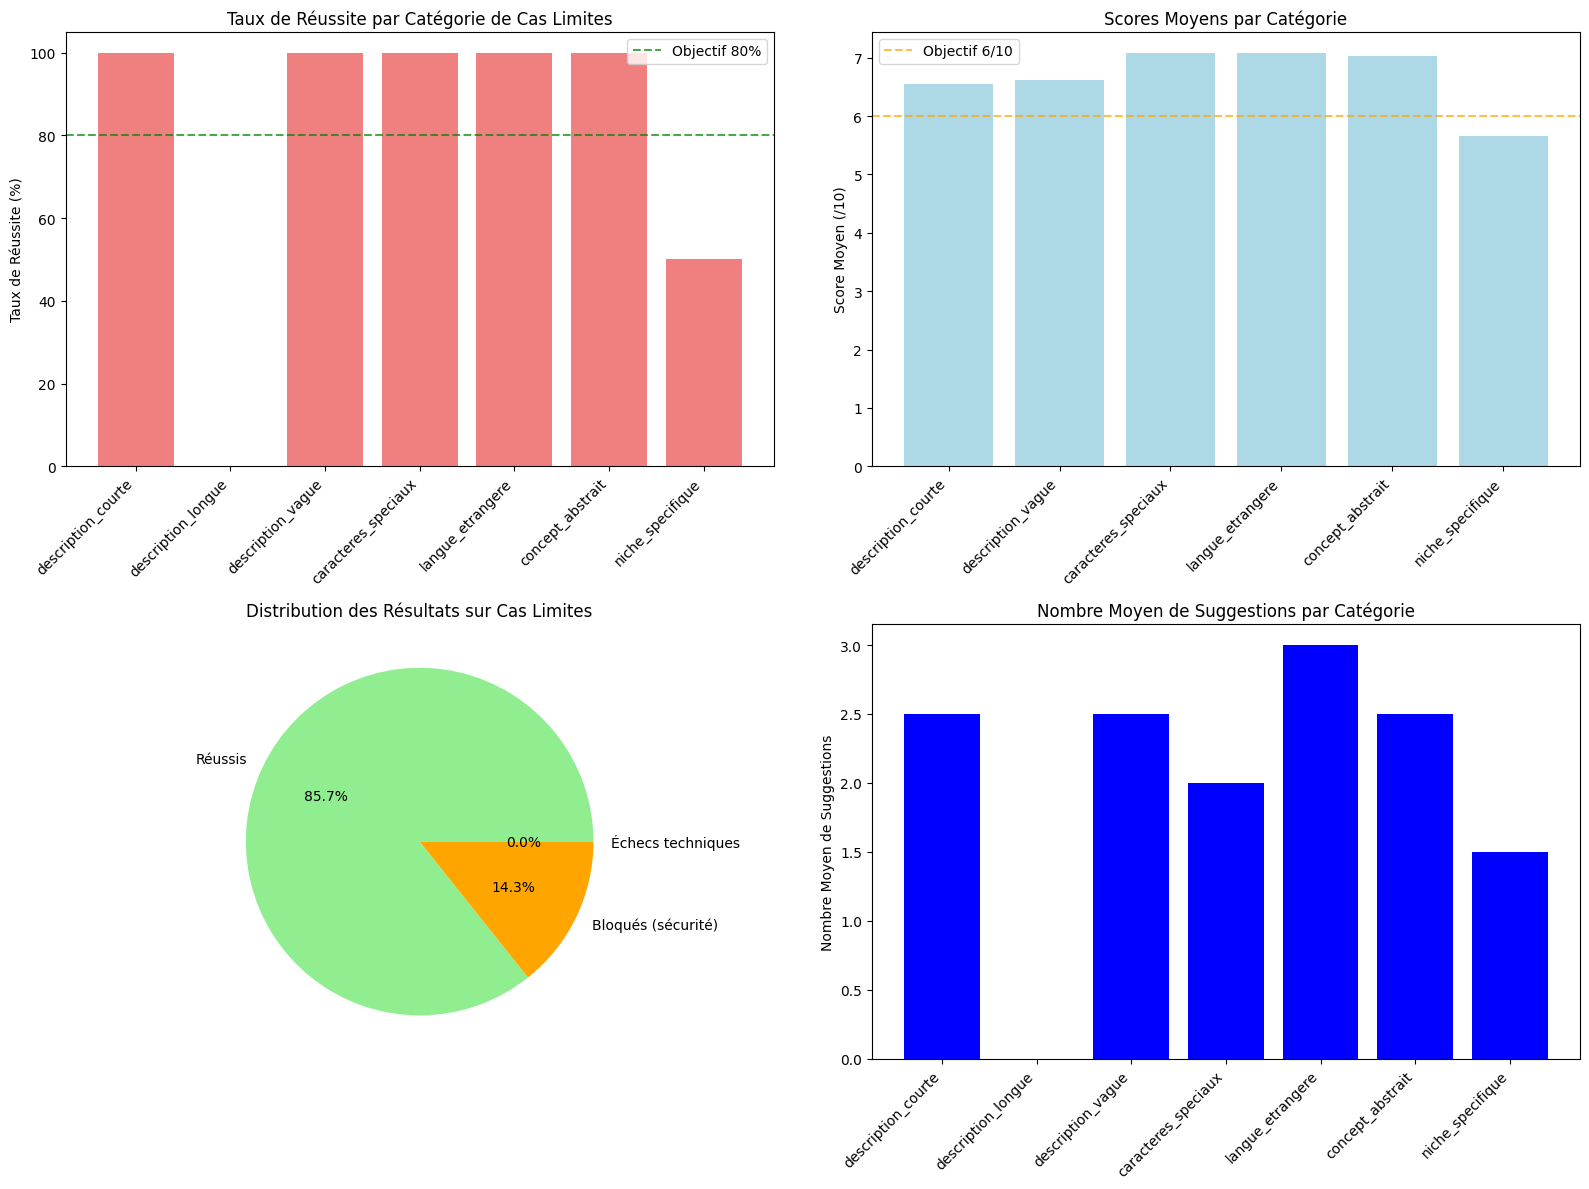

INFO:src.utils:Données sauvegardées dans ../data/evaluations/analyse_cas_limites_baseline.json



Catégories problématiques (< 50% de réussite):
   - description_longue: 0.0% de réussite

Catégories excellentes (≥ 80% de réussite):
   - description_courte: 100.0% de réussite
   - description_vague: 100.0% de réussite
   - caracteres_speciaux: 100.0% de réussite
   - langue_etrangere: 100.0% de réussite
   - concept_abstrait: 100.0% de réussite

Analyse des cas limites sauvegardée


In [14]:
# Analyse détaillée des résultats des cas limites
print("Analyse détaillée des performances sur les cas limites\n")

# Calculer les statistiques par catégorie
stats_categories = []

for categorie, resultats in resultats_cas_limites.items():
    nb_total = len(resultats)
    nb_reussis = len([r for r in resultats if r['nb_suggestions'] > 0])
    nb_bloques = len([r for r in resultats if r.get('type_echec') == 'filtrage_securite'])
    nb_echecs_tech = len([r for r in resultats if r.get('type_echec') == 'generation_failed'])
    
    scores_valides = [r['score_moyen'] for r in resultats if r['score_moyen'] is not None]
    score_moyen_categorie = np.mean(scores_valides) if scores_valides else 0
    
    suggestions_moyennes = np.mean([r['nb_suggestions'] for r in resultats])
    
    stats_categories.append({
        'categorie': categorie,
        'nb_total': nb_total,
        'nb_reussis': nb_reussis,
        'nb_bloques': nb_bloques,
        'nb_echecs_tech': nb_echecs_tech,
        'taux_reussite': (nb_reussis / nb_total) * 100,
        'score_moyen': score_moyen_categorie,
        'suggestions_moyennes': suggestions_moyennes
    })

# Créer un DataFrame pour l'analyse
df_stats = pd.DataFrame(stats_categories)

print("Statistiques par catégorie de cas limites:")
print(df_stats[['categorie', 'nb_total', 'taux_reussite', 'score_moyen', 'suggestions_moyennes']].round(2))

# Visualisations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Taux de réussite par catégorie
categories = df_stats['categorie']
taux_reussite = df_stats['taux_reussite']

axes[0,0].bar(range(len(categories)), taux_reussite, color='lightcoral')
axes[0,0].set_title('Taux de Réussite par Catégorie de Cas Limites')
axes[0,0].set_ylabel('Taux de Réussite (%)')
axes[0,0].set_xticks(range(len(categories)))
axes[0,0].set_xticklabels(categories, rotation=45, ha='right')
axes[0,0].axhline(y=80, color='green', linestyle='--', alpha=0.7, label='Objectif 80%')
axes[0,0].legend()

# Scores moyens par catégorie
scores_valides = df_stats[df_stats['score_moyen'] > 0]
if not scores_valides.empty:
    axes[0,1].bar(range(len(scores_valides)), scores_valides['score_moyen'], color='lightblue')
    axes[0,1].set_title('Scores Moyens par Catégorie')
    axes[0,1].set_ylabel('Score Moyen (/10)')
    axes[0,1].set_xticks(range(len(scores_valides)))
    axes[0,1].set_xticklabels(scores_valides['categorie'], rotation=45, ha='right')
    axes[0,1].axhline(y=6, color='orange', linestyle='--', alpha=0.7, label='Objectif 6/10')
    axes[0,1].legend()

# Distribution des types d'échecs
echecs_data = {
    'Réussis': df_stats['nb_reussis'].sum(),
    'Bloqués (sécurité)': df_stats['nb_bloques'].sum(),
    'Échecs techniques': df_stats['nb_echecs_tech'].sum()
}

axes[1,0].pie(echecs_data.values(), labels=echecs_data.keys(), autopct='%1.1f%%',
              colors=['lightgreen', 'orange', 'lightcoral'])
axes[1,0].set_title('Distribution des Résultats sur Cas Limites')

# Nombre moyen de suggestions par catégorie
axes[1,1].bar(range(len(categories)), df_stats['suggestions_moyennes'], color='blue')
axes[1,1].set_title('Nombre Moyen de Suggestions par Catégorie')
axes[1,1].set_ylabel('Nombre Moyen de Suggestions')
axes[1,1].set_xticks(range(len(categories)))
axes[1,1].set_xticklabels(categories, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Identifier les catégories problématiques
categories_problematiques = df_stats[df_stats['taux_reussite'] < 50]
categories_excellentes = df_stats[df_stats['taux_reussite'] >= 80]

print(f"\nCatégories problématiques (< 50% de réussite):")
if not categories_problematiques.empty:
    for _, row in categories_problematiques.iterrows():
        print(f"   - {row['categorie']}: {row['taux_reussite']:.1f}% de réussite")
else:
    print("   Aucune catégorie sous les 50%")

print(f"\nCatégories excellentes (≥ 80% de réussite):")
if not categories_excellentes.empty:
    for _, row in categories_excellentes.iterrows():
        print(f"   - {row['categorie']}: {row['taux_reussite']:.1f}% de réussite")
else:
    print("   Aucune catégorie au-dessus de 80%")

# Sauvegarder l'analyse des cas limites
sauvegarder_json({
    "timestamp": generer_timestamp(),
    "version": "baseline",
    "resultats_cas_limites": resultats_cas_limites,
    "statistiques_categories": stats_categories,
    "analyse": {
        "taux_reussite_global": df_stats['taux_reussite'].mean(),
        "score_moyen_global": df_stats['score_moyen'].mean(),
        "categories_problematiques": categories_problematiques['categorie'].tolist(),
        "categories_excellentes": categories_excellentes['categorie'].tolist()
    }
}, "../data/evaluations/analyse_cas_limites_baseline.json")

print("\nAnalyse des cas limites sauvegardée")